In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pest-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1569286%2F2583382%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240808%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240808T200446Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7a52948c025c3e2c370dc715d67244826e09b4abb85fc64b0a87b85618a24b0488a8e3bd2101dbf35ffce5069d6a2c32011e6066ab278f4e3ccc724203f63e208478d94ae697255d30f393bad1b9f9d3e99ce33c21fbb95cbfcaa219a4822e798c576c7cd67cc4ffb382d3b60a894ed153d37f71e814d187afcbde81251f0f64e813e484a57199523be24e83ee0464911dda0e69a7949ded1676a9ee11e525f0db4c93d9734e05559b25660a5e304a1a9797effba5ca672587439d7799c0310cc164aac3019d491d4de422150c7e7d19e440f274f3e70a2c3220c9a55e6cd9b4ac8266f2102b6c4f4b65276af80fd3f32daf45417d4e67ee810c7710403f4823'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 72828705 bytes downloaded
Downloaded and uncompressed: pest-dataset
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

In [4]:
img=np.array(img)
img.shape

(225, 225, 3)

In [5]:
train_dir='../input/pest-dataset/pest/train/'
test_dir='../input/pest-dataset/pest/test/'



training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)


Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


In [6]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [9]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]
#model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
#callback=[EarlyStop , Reduce_LR,model_check]

In [10]:
mobilenet.trainable=False

In [11]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(9,activation='softmax')
])

In [13]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [23]:
history=model.fit(training,validation_data=validing,epochs=5,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=2)

Epoch 1/5
10/10 - 12s - 1s/step - accuracy: 0.8500 - loss: 0.4027 - val_accuracy: 0.5000 - val_loss: 2.4835 - learning_rate: 0.0010
Epoch 2/5
10/10 - 10s - 1s/step - accuracy: 0.8875 - loss: 0.2705 - val_accuracy: 0.7500 - val_loss: 1.2982 - learning_rate: 0.0010
Epoch 3/5
10/10 - 10s - 1s/step - accuracy: 0.8875 - loss: 0.3470 - val_accuracy: 0.6875 - val_loss: 2.1665 - learning_rate: 0.0010
Epoch 4/5
10/10 - 9s - 863ms/step - accuracy: 0.9062 - loss: 0.3640 - val_accuracy: 0.7500 - val_loss: 1.3388 - learning_rate: 0.0010
Epoch 5/5
10/10 - 10s - 1s/step - accuracy: 0.8562 - loss: 0.4253 - val_accuracy: 0.8125 - val_loss: 0.6015 - learning_rate: 0.0010


In [24]:
loss , acc = model.evaluate(testing)

29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 724ms/step - accuracy: 0.6805 - loss: 1.5423


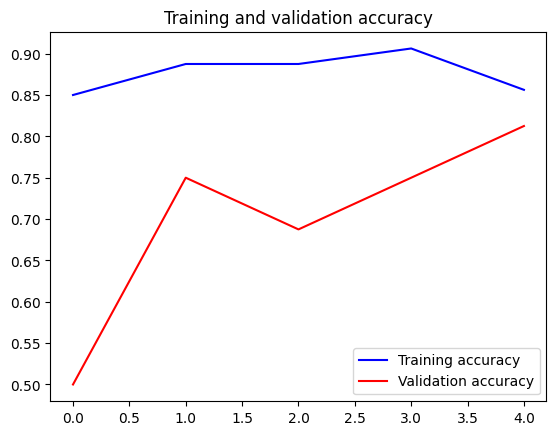

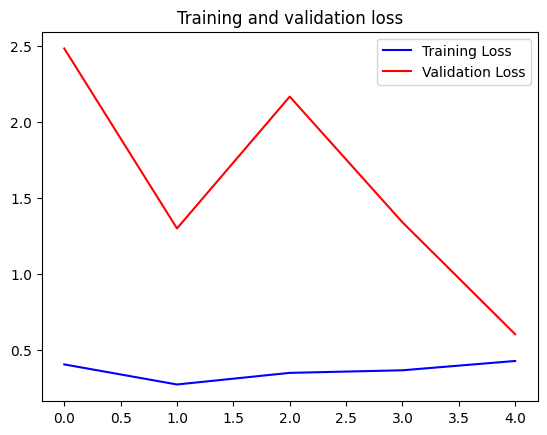

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
testing_1=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=1,target_size=(224,224),shuffle=False)

def determinePest(int):
  pests= ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']
  return pests[int]


Found 450 images belonging to 9 classes.


In [34]:
determinePest(np.argmax(model.predict(testing_1[6])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


'aphids'

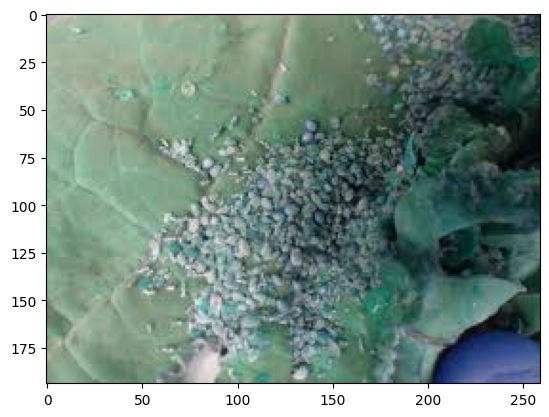

In [35]:
img=cv2.imread('../input/pest-dataset/pest/train/aphids/jpg_15.jpg')
plt.imshow(img)
plt.show()